[https://github.com/apple/ml-fastvlm/tree/main](https://github.com/apple/ml-fastvlm/tree/main)

## import librarys

In [3]:
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
MID = "apple/FastVLM-0.5B"
IMAGE_TOKEN_INDEX = -200  # what the model code looks for

# Load
tok = AutoTokenizer.from_pretrained(MID, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MID,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


In [87]:
# Build chat -> render to string (not tokens) so we can place <image> exactly
messages = [
    {"role": "user", "content": "<image>\nHow many fingers is the person holding up? Respond using only a single digit (0-5). Output must be only the digit, no text or punctuation."}
]

rendered = tok.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=False
)
rendered

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image>\nHow many fingers is the person holding up? Respond using only a single digit (0-5). Output must be only the digit, no text or punctuation.<|im_end|>\n<|im_start|>assistant\n'

In [88]:
pre, post = rendered.split("<image>", 1)

# Tokenize the text *around* the image token (no extra specials!)
pre_ids  = tok(pre,  return_tensors="pt", add_special_tokens=False).input_ids
post_ids = tok(post, return_tensors="pt", add_special_tokens=False).input_ids

In [89]:
# Splice in the IMAGE token id (-200) at the placeholder position
img_tok = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)
input_ids = torch.cat([pre_ids, img_tok, post_ids], dim=1).to(model.device)
attention_mask = torch.ones_like(input_ids, device=model.device)

In [67]:
!wget -O hand-gesture.webp "https://github.com/Alireza-Akhavan/datasets_and_models/blob/main/number-one-hand-gesture.webp?raw=true"

--2025-09-10 04:28:33--  https://github.com/Alireza-Akhavan/datasets_and_models/blob/main/number-one-hand-gesture.webp?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/number-one-hand-gesture.webp [following]
--2025-09-10 04:28:34--  https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/number-one-hand-gesture.webp
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/number-one-hand-gesture.webp [following]
--2025-09-10 04:28:34--  https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/number-one-hand-gesture.webp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 18

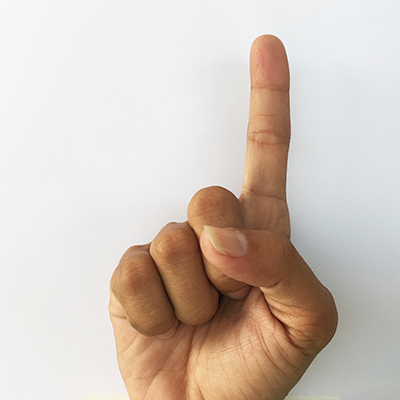

In [68]:
img = Image.open("hand-gesture.webp").convert("RGB")
img

In [95]:
# Preprocess image via the model's own processor
px = model.get_vision_tower().image_processor(images=img, return_tensors="pt")["pixel_values"]
px = px.to(model.device, dtype=model.dtype)

# Generate
with torch.no_grad():
    out = model.generate(
        inputs=input_ids,
        attention_mask=attention_mask,
        images=px,
        max_new_tokens=1,
        do_sample=False
    )

print(tok.decode(out[0], skip_special_tokens=True))


1


In [108]:
!wget -O cats.jpg https://github.com/Alireza-Akhavan/datasets_and_models/blob/main/cats.jpg?raw=true

--2025-09-10 04:42:07--  https://github.com/Alireza-Akhavan/datasets_and_models/blob/main/cats.jpg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/cats.jpg [following]
--2025-09-10 04:42:07--  https://github.com/Alireza-Akhavan/datasets_and_models/raw/refs/heads/main/cats.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/cats.jpg [following]
--2025-09-10 04:42:07--  https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/refs/heads/main/cats.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.gi

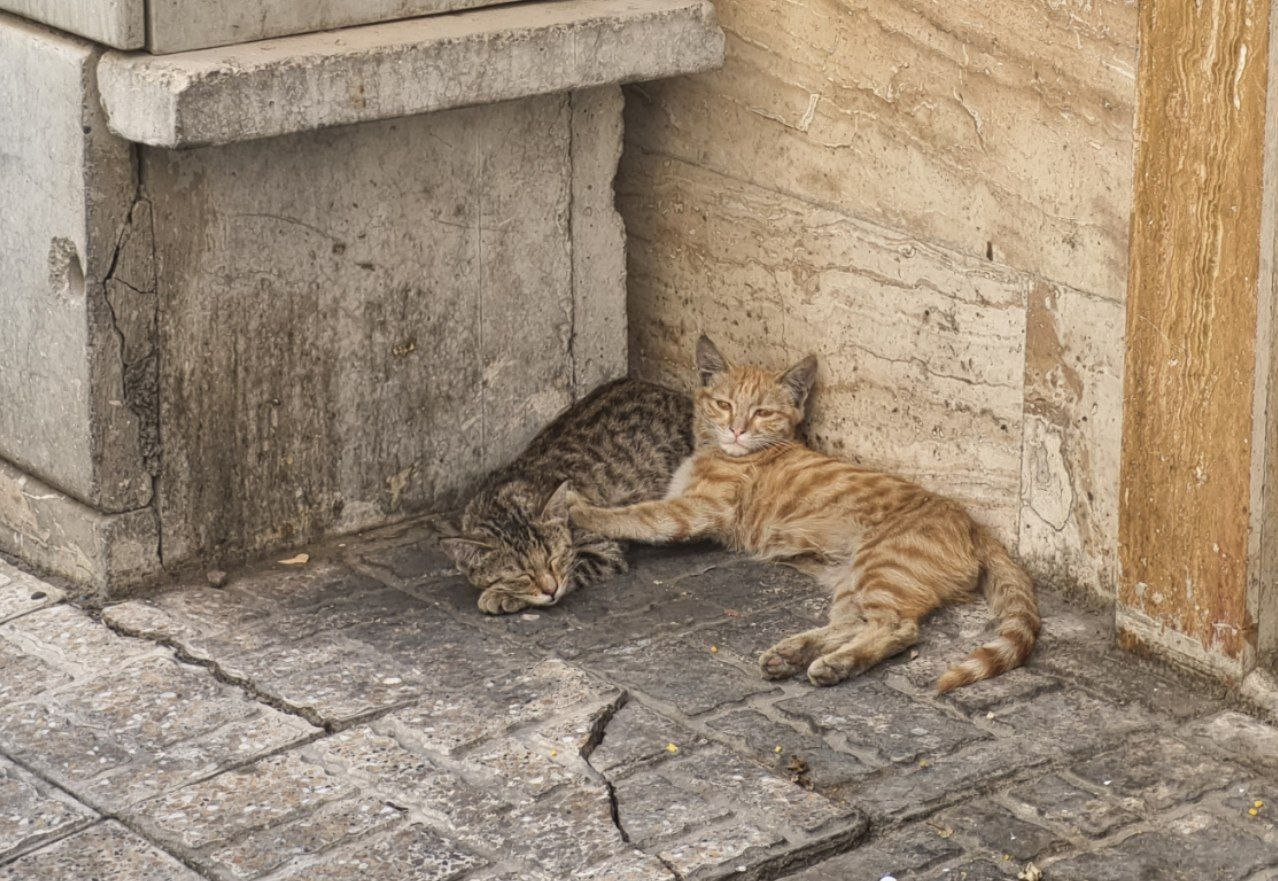

In [109]:
img = Image.open("cats.jpg").convert("RGB")
img

In [115]:
# Build chat -> render to string (not tokens) so we can place <image> exactly
messages = [
    {"role": "user", "content": "<image>\nDescribe this image in detail."}
]

rendered = tok.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=False
)
pre, post = rendered.split("<image>", 1)
# Tokenize the text *around* the image token (no extra specials!)
pre_ids  = tok(pre,  return_tensors="pt", add_special_tokens=False).input_ids
post_ids = tok(post, return_tensors="pt", add_special_tokens=False).input_ids
# Splice in the IMAGE token id (-200) at the placeholder position
img_tok = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)
input_ids = torch.cat([pre_ids, img_tok, post_ids], dim=1).to(model.device)
attention_mask = torch.ones_like(input_ids, device=model.device)
# Preprocess image via the model's own processor
px = model.get_vision_tower().image_processor(images=img, return_tensors="pt")["pixel_values"]
px = px.to(model.device, dtype=model.dtype)

# Generate
with torch.no_grad():
    out = model.generate(
        inputs=input_ids,
        attention_mask=attention_mask,
        images=px,
        max_new_tokens=256,
    )

print(tok.decode(out[0], skip_special_tokens=True))


The image depicts an outdoor scene featuring two cats resting in a narrow alcove or alcove of what appears to be a stone staircase. The stone structure surrounding the alcove is composed of light-colored stone, likely a blend of limestone or another type of natural stone, and shows signs of weathering with some visible cracks. 

On the left side of the alcove, a tabby cat is lying down with its eyes partially closed in a relaxed position. This cat has a classic tabby pattern with a mix of black and brown stripes. Its body is slightly curved towards the left.

On the right side of the alcove, an orange tabby cat is sitting upright, stretching out with its front paws in front of it and its head tilted slightly upwards. The orange tabby also has distinct tabby markings, with a pattern of bold orange stripes and patches of light brown interspersed with the red.

Both cats appear to be at ease and are likely using the alcove as a resting spot and a vantage point, possibly in a domestic or s